In [3]:
import numpy as np
import torch
from torchvision.models import ViT_B_32_Weights, vit_b_32

from wings.config import MODELS_DIR, PROCESSED_DATA_DIR
from wings.modeling.litnet import LitNet
from wings.modeling.models import TransformerPreTrained
from wings.visualizing.image_preprocess import denormalize
from wings.visualizing.visualize import visualize_coords

In [227]:
test_dataset = torch.load(PROCESSED_DATA_DIR / "test_dataset.pth", weights_only=False)
checkpoint_path = MODELS_DIR / 'transformer32-epoch=51-val_loss=17.39-test-transformer_1.ckpt'
# checkpoint_path = MODELS_DIR / 'transformer-epoch=56-val_loss=17.36-v03.ckpt'
weights = ViT_B_32_Weights.DEFAULT
transformer_model = TransformerPreTrained(vit_b_32, weights)

num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=transformer_model, num_epochs=num_epochs)
model.eval()

max_n = len(test_dataset)

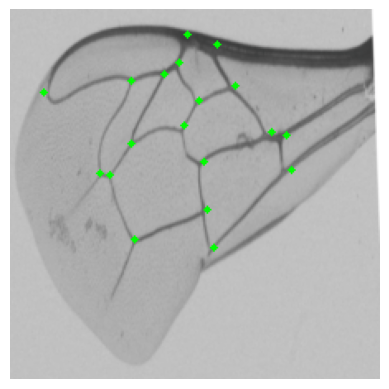

In [285]:
n = np.random.randint(0, max_n)
image, label = test_dataset[n]
labels = model(image.cuda().unsqueeze(0))
image = denormalize(image)
visualize_coords(image, labels.squeeze(0), spot_size=2)